In [1]:
import os


import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression as LR

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u

ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice


%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
figdir = "/mnt/BigDisk/YMazeResults/neural/novel_arm_activity"
os.makedirs(figdir, exist_ok=True)

In [7]:
class ActivityRate:
    
    def __init__(self, days = np.arange(6), pos_bin=False, pos_avg = True, block = 5, cell_avg=True, novel_only = False, fam_only=False):
        
        self.ko_mice = ko_mice
        self.ctrl_mice = ctrl_mice
        
        self.days = days
        self.n_days = days.shape[0]
        
        self.pos_bin = pos_bin
        self.pos_avg = pos_avg
        self.block = block
        self.cell_avg = cell_avg
        self.novel_only = novel_only
        self.fam_only = fam_only
        
        self.ko_data = self.mouse_loop(ko_mice)
        self.ctrl_data = self.mouse_loop(ctrl_mice)
        
    @staticmethod
    def get_act_rate(sess, block=5, pos_bin=False, pos_avg = True, t_post = 40, cell_avg = True, novel_only = False, fam_only=False):
        '''
        
        
        '''
        
        last_block_ind = np.argwhere(sess.trial_info['block_number']==block)[0][0]
        lr = np.zeros([t_post,])*np.nan
        _lr = sess.trial_info['LR'][last_block_ind:last_block_ind+t_post]
        lr[:_lr.shape[0]]=_lr
        
        if pos_bin:
            if pos_avg:
                
                mu = np.zeros([t_post,])*np.nan
                speed = np.zeros([t_post,])*np.nan
                
            
                baseline_tmat = sess.trial_matrices['spks'][last_block_ind-10:last_block_ind,:,:]
                tmat = sess.trial_matrices['spks'][last_block_ind:last_block_ind+t_post,:,:]
                if novel_only:
                    tmat = tmat[_lr==sess.novel_arm,:,:]
                
                if fam_only:
                    tmat = tmat[_lr==-1*sess.novel_arm,:,:]
                    
                

                baseline_mu = (np.nanmean(baseline_tmat, axis=1, keepdims=True)/np.nanmean(np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=1, keepdims=True)).mean(axis=-1).ravel()
                
                mu[:tmat.shape[0]] = (np.nanmean(tmat, axis=1, keepdims=True)/np.nanmean(np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=1, keepdims=True)).mean(axis=-1).ravel()

                _baseline_speed = np.nanmean(sess.trial_matrices['speed'][last_block_ind-10:last_block_ind, :], axis=-1)
                _speed = np.nanmean(sess.trial_matrices['speed'][last_block_ind:last_block_ind+t_post,:],axis=-1)/_baseline_speed.mean(axis=0,keepdims=True)
                if novel_only:
                    _speed = _speed[_lr==sess.novel_arm]
                    
                if fam_only:
                    _speed = _speed[_lr==-1*sess.novel_arm]
                    
                speed[:tmat.shape[0]] = _speed #np.nanmean(sess.trial_matrices['speed'][last_block_ind:last_block_ind+t_post, :], axis=-1)/_baseline_speed.mean(keepdims=True)
                
                baseline_speed = _baseline_speed/_baseline_speed.mean()
            else:
                
                

                speed = np.zeros([t_post, sess.trial_matrices['speed'].shape[1]])*np.nan
                
                if cell_avg:
                    mu = np.zeros([t_post, sess.trial_matrices['spks'].shape[1]])*np.nan
                    baseline_tmat = sess.trial_matrices['spks'][last_block_ind-10:last_block_ind, :, :] +1E-5
                    tmat = sess.trial_matrices['spks'][last_block_ind:last_block_ind+t_post,:,:]
                    if novel_only:
                        tmat = tmat[_lr==sess.novel_arm,:,:]
                


                    baseline_mu = np.nanmean(baseline_tmat/np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=-1)
                    
                    mu[:tmat.shape[0], :] = np.nanmean(tmat/np.nanmean(np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=1, keepdims=True), axis=-1)
    #                 mu[:tmat.shape[0], :] = np.nanmean(tmat/np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=-1)
                    
                else:
                    mu = np.zeros([t_post, *sess.trial_matrices['spks'].shape[1:]])*np.nan
                    baseline_tmat = sess.trial_matrices['spks'][last_block_ind-10:last_block_ind, :, :] +1E-5
                    tmat = sess.trial_matrices['spks'][last_block_ind:last_block_ind+t_post,:,:]


    #                 baseline_mu = np.nanmean(baseline_tmat/np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=-1)
                    baseline_mu = baseline_tmat/np.nanmean(baseline_tmat, axis=0, keepdims=True)
                    mu[:tmat.shape[0], :, :] = tmat/np.nanmean(np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=1, keepdims=True)
    #                 mu[:tmat.shape[0], :] = np.nanmean(tmat/np.nanmean(np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=1, keepdims=True), axis=-1)
    #                 mu[:tmat.shape[0], :] = np.nanmean(tmat/np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=-1)

                
                _baseline_speed = np.nanmean(sess.trial_matrices['speed'][last_block_ind-10:last_block_ind, :], axis=-1)
                _speed = sess.trial_matrices['speed'][last_block_ind:last_block_ind+t_post,:]/_baseline_speed.mean(axis=0,keepdims=True)
                if novel_only:
                    _speed = _speed[_lr==sess.novel_arm,:]
                speed[:tmat.shape[0], :] = _speed #sess.trial_matrices['speed'][last_block_ind:last_block_ind+t_post,:]/_baseline_speed.mean(axis=0,keepdims=True)
                
                baseline_speed = _baseline_speed/_baseline_speed.mean(axis=0, keepdims=True)
      
            
        else:
            
            # TODO: 
            _baseline_mu = np.zeros([10,sess.timeseries['spks'].shape[0]])*np.nan
            mu = np.zeros([t_post,sess.timeseries['spks'].shape[0]])*np.nan
            
            _baseline_speed = np.zeros([10,])*np.nan
            speed = np.zeros([t_post,])*np.nan
            
            baseline_starts, baseline_stops = sess.trial_start_inds[last_block_ind-10:last_block_ind], sess.teleport_inds[last_block_ind-10:last_block_ind]
            for i, (start, stop) in enumerate(zip(baseline_starts, baseline_stops)):
                _baseline_mu[i,:] = sess.timeseries['spks'][:,start:stop].mean(axis=-1)
                _baseline_speed[i] = sess.timeseries['speed'][0,start:stop].mean()
            
            starts, stops = sess.trial_start_inds[last_block_ind:last_block_ind+t_post], sess.teleport_inds[last_block_ind:last_block_ind+t_post]
            for i, (start, stop) in enumerate(zip(starts,stops)):
                mu[i,:] = sess.timeseries['spks'][:,start:stop].mean(axis=-1)
                speed[i] = sess.timeseries['speed'][0,start:stop].mean()
            
            
            baseline_mu = (_baseline_mu/_baseline_mu.mean(axis=0,keepdims=True)).mean(axis=-1) 
            mu = (mu/_baseline_mu.mean(axis=0,keepdims=True)).mean(axis=-1)
            
            
            baseline_speed = _baseline_speed/_baseline_speed.mean()
            speed /= _baseline_speed.mean()
#             print(speed.shape)
            
        return mu, baseline_mu, speed, baseline_speed, lr
    
    
    def mouse_loop(self, mice):
        
        d= {}
        for mouse in mice:
            d[mouse] = {'mu': [], 'baseline_mu': [], 'speed': [], 'baseline_speed': [], 'famnov': [], 'place_cell_info': []}
            for day in self.days:
                sess = u.load_single_day(mouse, day, verbose=False)
                mu, baseline_mu, speed, baseline_speed, lr = self.get_act_rate(sess, block=self.block, pos_bin = self.pos_bin, 
                                                                               pos_avg = self.pos_avg, cell_avg = self.cell_avg, 
                                                                               novel_only = self.novel_only, fam_only = self.fam_only)
                d[mouse]['mu'].append(mu)
                d[mouse]['baseline_mu'].append(baseline_mu)
                d[mouse]['speed'].append(speed)
                d[mouse]['baseline_speed'].append(baseline_speed)
                d[mouse]['famnov'].append(lr*sess.novel_arm) # 1 = novel, -1 familiar
                d[mouse]['place_cell_info'].append(sess.place_cell_info)
                
        return d
    
    
    
    @staticmethod
    def make_plot_arr(data_dict, day):
        
        mu, baseline_mu, speed, baseline_speed, lr = [], [], [], [], []
        for mouse in data_dict.keys():
            mu.append(data_dict[mouse]['mu'][day])
            baseline_mu.append(data_dict[mouse]['baseline_mu'][day])
            speed.append(data_dict[mouse]['speed'][day])
            baseline_speed.append(data_dict[mouse]['baseline_speed'][day])
            lr.append(data_dict[mouse]['famnov'][day])
            
        return np.array(mu), np.array(baseline_mu), np.array(speed), np.array(baseline_speed), np.array(lr)
    

    def mixed_anova(self):
        
        df = {'ko_ctrl': [],
              'day': [],
              'mu': [],
              'speed': [],
              'mouse': [],
              'famnov': []}

        for mouse in range(len(self.ko_mice)):
            for day in self.days:
                
                df['ko_ctrl'].append(0)
                df['day'].append(day)
                
                df['frac'].append(np.nanmean(self.ko_data[mouse]['mu'][day]))
                df['mouse'].append(mouse)

        for mouse in range(len(self.ctrl_mice)):
            for day in self.days:
                df['ko_ctrl'].append(1)
                df['day'].append(day)
                df['frac'].append(np.nanmean(self.ko_data[mouse]['mu'][day]))
                df['mouse'].append(mouse + 5)

        df = pd.DataFrame(df)
        results = {}
        aov = mixed_anova(data=df, dv='frac', between='ko_ctrl', within='day', subject='mouse')
        results['anova'] = aov
        if verbose:
            print('Mixed design ANOVA results')
            print(aov)

        if group_tukey:
            ko_ctrl_tukey = pairwise_tukey(data=df, dv='frac', between='ko_ctrl')
            results['ko_ctrl_tukey'] = ko_ctrl_tukey
            if verbose:
                print('PostHoc Tukey: KO vs Ctrl')
                print(ko_ctrl_tukey)

        if day_tukey:
            day_stats = []
            print('PostHov Tukey on each day')
            for day in self.days:
                print('Day %d' % day)
                stats = pairwise_tukey(data=df[df['day'] == day], dv='frac', between='ko_ctrl')
                day_stats.append(stats)
                if verbose:
                    print(stats)
            results['day_tukey'] = day_stats

        return results
            
            
    
    @staticmethod
    def mu_sem(arr, axis=0):
        return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
        
    
    def plot_activity_rates(self):
        
        
        fig_mu,ax_mu = plt.subplots(2, self.n_days, sharey=True, figsize= [5 * self.n_days, 10])
        fig_mu.suptitle('Activty Rate')
        fig_speed,ax_speed = plt.subplots(2, self.n_days, sharey=True, figsize= [5 * self.n_days, 10])
        fig_speed.suptitle('Speed')
        
        x_baseline = np.arange(-10,0)
        x_ = np.arange(0,40)
        for d, day in enumerate(self.days):
            ko_mu, ko_baseline_mu, ko_speed, ko_baseline_speed, ko_lr = self.make_plot_arr(self.ko_data, d)
            ctrl_mu, ctrl_baseline_mu, ctrl_speed, ctrl_baseline_speed, ctrl_lr = self.make_plot_arr(self.ctrl_data, d)
        
            # baseline mu
            ax_mu[0,d].plot(x_baseline, ko_baseline_mu.T , color= 'red')
            
            _mu, _sem = self.mu_sem(ko_baseline_mu)
            ax_mu[1,d].fill_between(x_baseline, _mu-_sem, _mu+_sem, color='red', alpha = .3)
            
            
            ax_mu[0,d].plot(x_baseline, ctrl_baseline_mu.T , color= 'black')
            
            _mu, _sem = self.mu_sem(ctrl_baseline_mu)
            ax_mu[1,d].fill_between(x_baseline, _mu-_sem, _mu+_sem, color='black', alpha = .3)
            
            # mu
            ax_mu[0,d].plot(x_, ko_mu.T , color= 'red')
            
            _mu, _sem = self.mu_sem(ko_mu)
            ax_mu[1,d].fill_between(x_, _mu-_sem, _mu+_sem, color='red', alpha = .3)
            
            
            ax_mu[0,d].plot(x_, ctrl_mu.T , color= 'black')
            
            _mu, _sem = self.mu_sem(ctrl_mu)
            ax_mu[1,d].fill_between(x_, _mu-_sem, _mu+_sem, color = 'black', alpha = .3)
            
            # baseline_speed
            ax_speed[0,d].plot(x_baseline, ko_baseline_speed.T , color= 'red')
            
            _mu, _sem = self.mu_sem(ko_baseline_mu)
            ax_speed[1,d].fill_between(x_baseline, _mu-_sem, _mu+_sem, color='red', alpha = .3)
            
            
            ax_speed[0,d].plot(x_baseline, ctrl_baseline_speed.T , color= 'black')
            
            _mu, _sem = self.mu_sem(ctrl_baseline_speed)
            ax_speed[1,d].fill_between(x_baseline, _mu-_sem, _mu+_sem, color='black', alpha = .3)
            
            # speed
            ax_speed[0,d].plot(x_, ko_speed.T , color= 'red')
            
            _mu, _sem = self.mu_sem(ko_speed)
            ax_speed[1,d].fill_between(x_, _mu-_sem, _mu+_sem, color='red', alpha = .3)
            
            
            ax_speed[0,d].plot(x_, ctrl_speed.T , color= 'black')
            
            _mu, _sem = self.mu_sem(ctrl_speed)
            ax_speed[1,d].fill_between(x_, _mu-_sem, _mu+_sem, color = 'black', alpha = .3)
            
            for r in [0,1]:
                ax_mu[r, d].spines['top'].set_visible(False)
                ax_mu[r, d].spines['right'].set_visible(False)
                
                ax_speed[r, d].spines['top'].set_visible(False)
                ax_speed[r, d].spines['right'].set_visible(False)
        return (fig_mu, ax_mu), (fig_speed, ax_speed)

In [8]:
ar = ActivityRate(days = np.arange(6), block=5, pos_bin=True, pos_avg=True, novel_only=True, fam_only=False)

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUti

02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
['LR', 'block_number']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


Day 0
-3.4858026940008426 0.008249065910018956
Day 1
-4.180657890263867 0.003076846163984262
Day 2
-4.929672731979874 0.0011499129004744748
Day 3
-3.074340666963977 0.015247192738941586
Day 4
-4.664634395818779 0.0016137119487836503
Day 5
-1.0267940612731339 0.3345595059220633


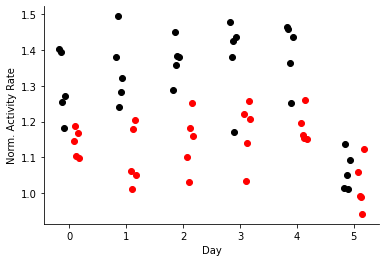

In [9]:
fig, ax = plt.subplots()
for day in ar.days:
    _ko = np.array([np.nanmean(ar.ko_data[mouse]['mu'][day]) for mouse in ar.ko_mice])
    _ctrl = np.array([np.nanmean(ar.ctrl_data[mouse]['mu'][day]) for mouse in ar.ctrl_mice])
    
    t,p = sp.stats.ttest_ind(_ko,_ctrl)
    print('Day', day)
    print(t,p)
    
    ax.scatter(0*_ko + np.linspace(-.1,.1, num=5) + 2*day+.25, _ko, color='red')
    ax.scatter(0*_ko + np.linspace(-.1,.1, num=5) + 2*day -.25 , _ctrl, color='black')
ax.set_ylabel('Norm. Activity Rate')
ax.set_xlabel('Day')
ax.set_xticks([0,2,4,6,8,10])
ax.set_xticklabels([0,1,2,3,4,5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(figdir,"alldays_novelactrate.pdf"),format = 'pdf')

<ipython-input-4-d6440fb41406>:232: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
<ipython-input-4-d6440fb41406>:232: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
<ipython-input-4-d6440fb41406>:232: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
<ipython-input-4-d6440fb41406>:232: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
<ipython-input-4-d6440fb41406>:232: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
<ipython-input-4-d6440fb41406>:232: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
<ipython-input-4-d6440fb41406>:232: RuntimeWarning: Mean of empt

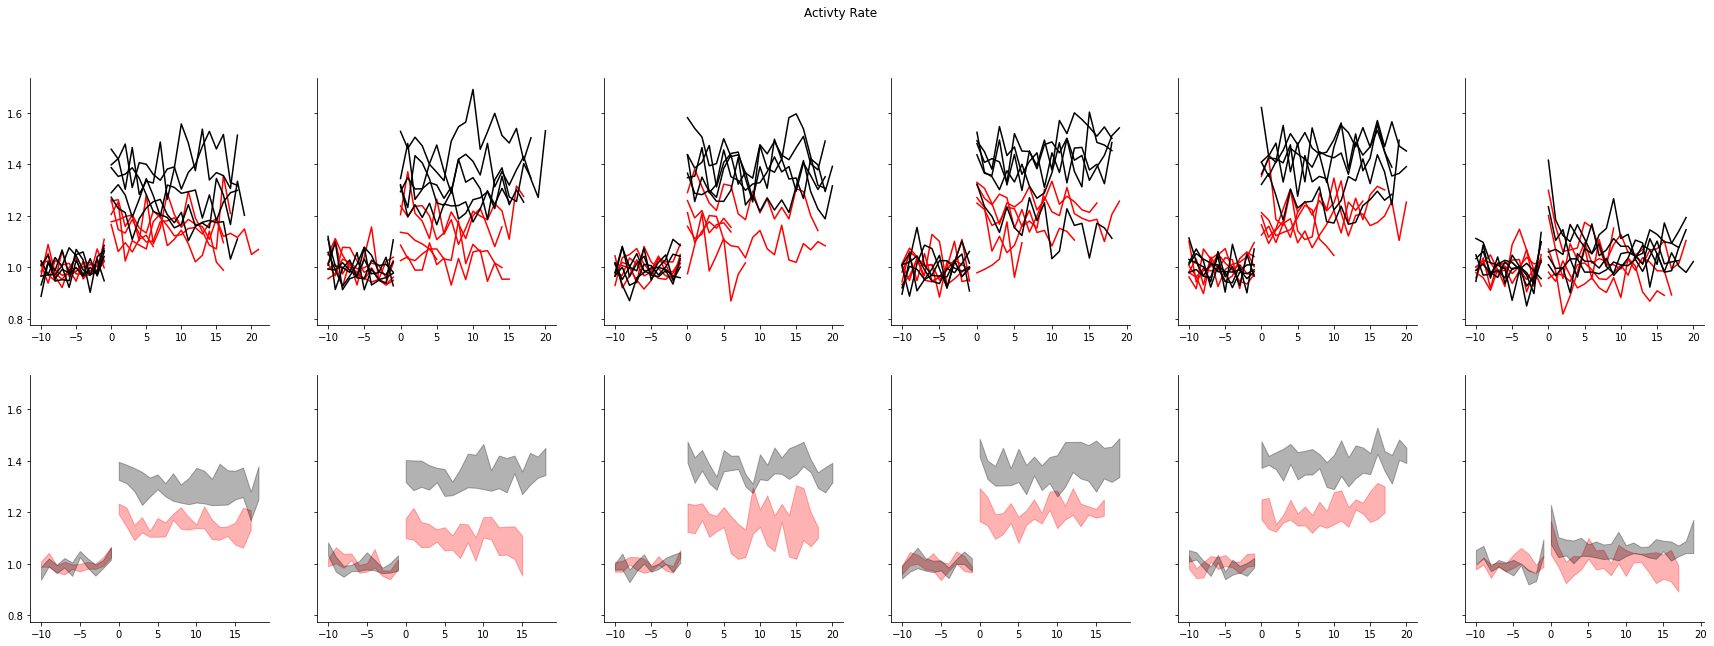

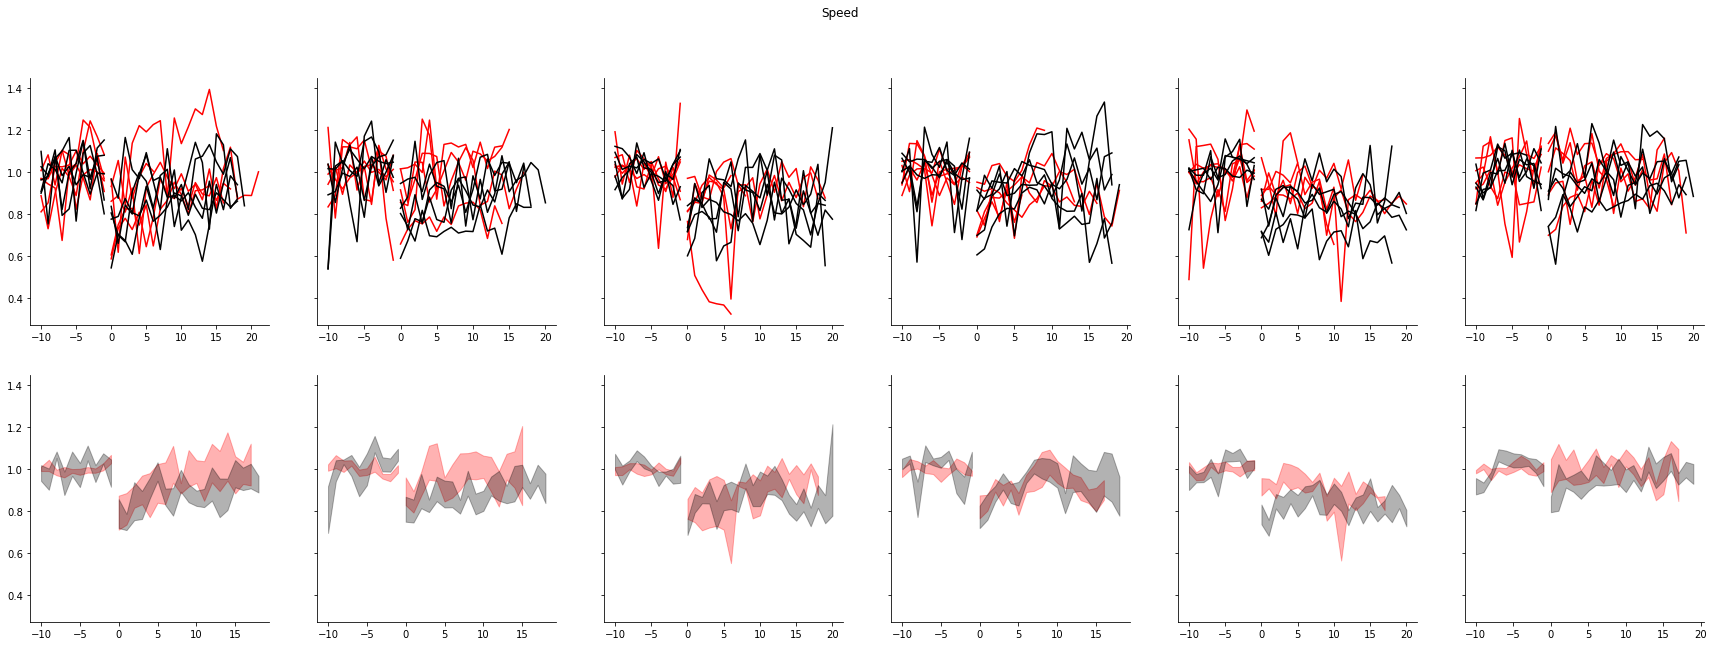

In [25]:
(fig_mu, ax_mu), (fig_speed, ax_speed) = ar.plot_activity_rates()
# fig_mu.savefig(os.path.join(figdir,'novel_only_block5_activity.pdf'),format='pdf')
# fig_speed.savefig(os.path.join(figdir,'novel_only_block5_speed.pdf'),format='pdf')


In [15]:
ar = ActivityRate(days = np.arange(6), block=5, pos_bin=True, pos_avg=True, novel_only=False, fam_only=False)

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUti

02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


<ipython-input-12-d6440fb41406>:232: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
<ipython-input-12-d6440fb41406>:232: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
<ipython-input-12-d6440fb41406>:232: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
<ipython-input-12-d6440fb41406>:232: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')


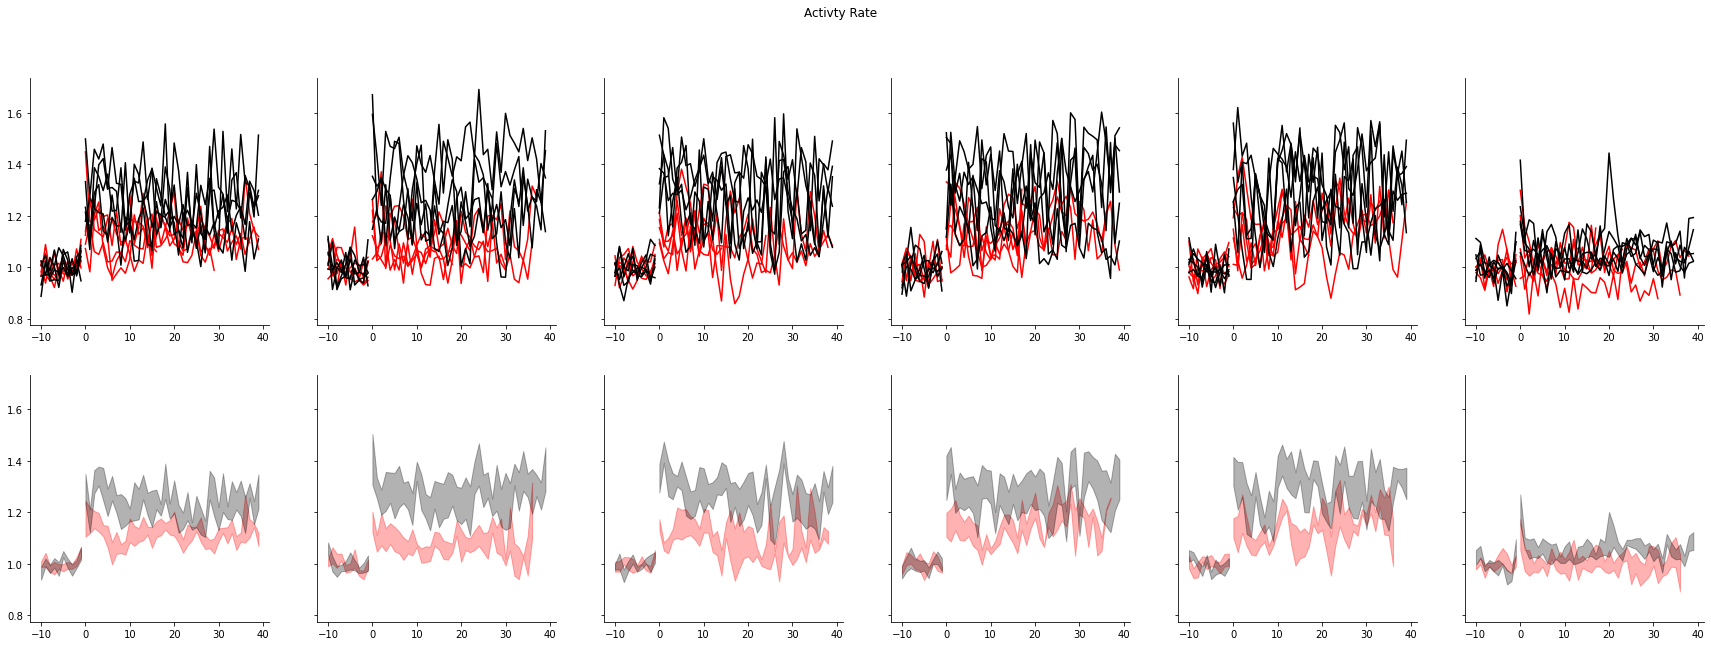

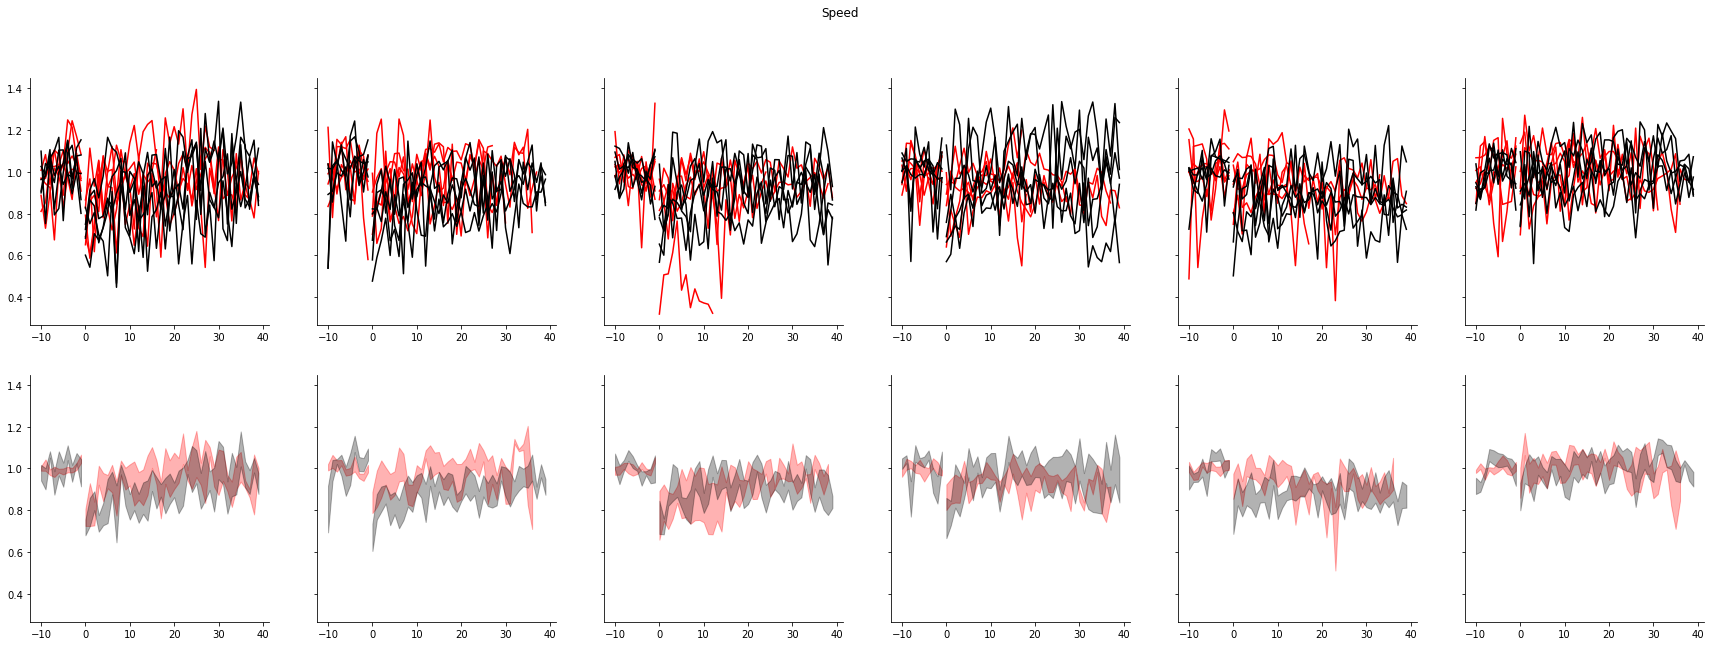

In [16]:
(fig_mu, ax_mu), (fig_speed, ax_speed) = ar.plot_activity_rates()
# fig_mu.savefig(os.path.join(figdir,'alltrials_block5_activity.pdf'),format='pdf')
# fig_speed.savefig(os.path.join(figdir,'alltrials_block5_speed.pdf'),format='pdf')


In [17]:
ar = ActivityRate(days = np.arange(6), block=5, pos_bin=True, pos_avg=False, novel_only=False, fam_only=False)

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
<ipython-input-12-d6440fb41406>:82: RuntimeWarning: Mean of empty slice
  mu[:tmat.shape[0], :] = np.nanmean(tmat/np.nanmean(np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=1, keepdims=True), axis=-1)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could 

02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


(5, 40)


ValueError: x and y must have same first dimension, but have shapes (30,) and (5,)

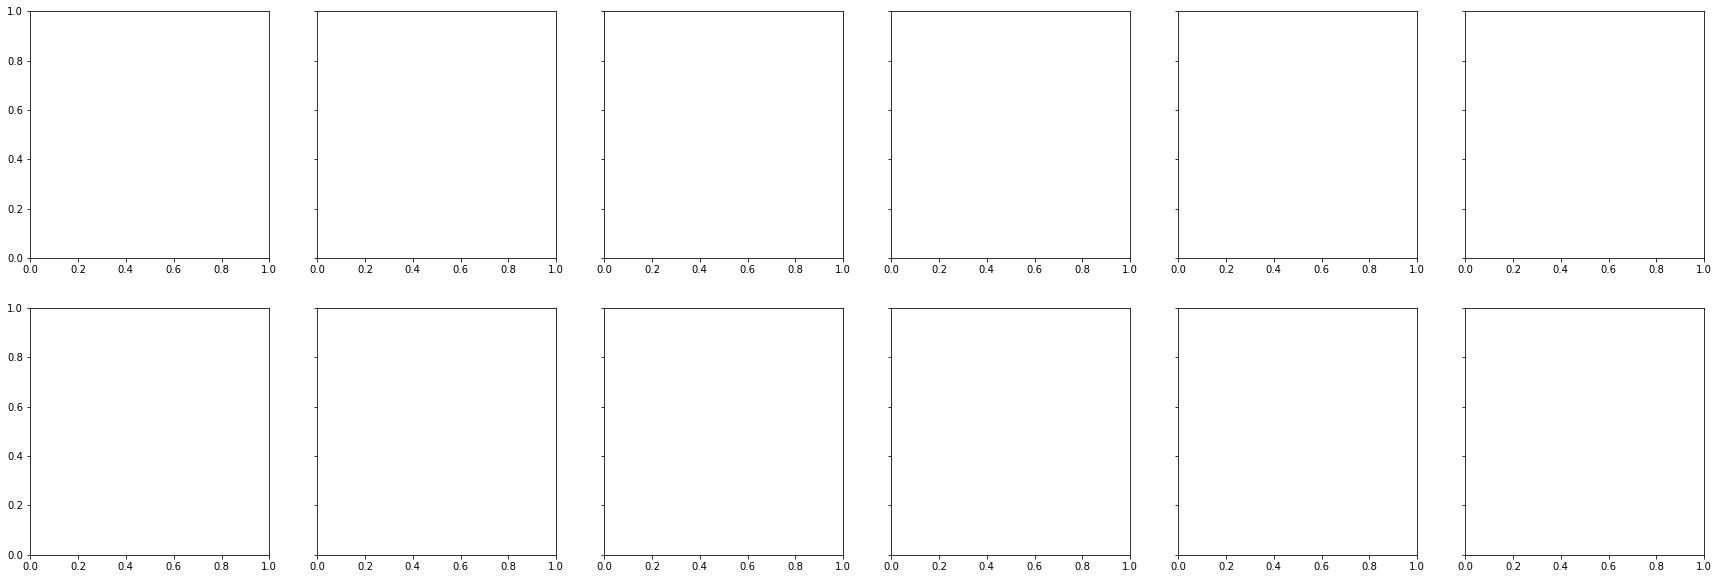

In [26]:
fig,ax = plt.subplots(2,6, figsize = [30,10], sharey=True)

x = np.arange(30)
for day in range(6):

    ctrl_mu, _, speed, _, ctrl_lr = ar.make_plot_arr(ar.ctrl_data,day)
    print(ctrl_mu.shape)
    ko_mu, _, speed, _, ko_lr = ar.make_plot_arr(ar.ko_data,day)

    ax[0,day].plot(x, np.nanmean(ctrl_mu,axis=1).T, color='black')
    mu, sem = ar.mu_sem(np.nanmean(ctrl_mu, axis=1))
    ax[1,day].fill_between(x, mu-sem, mu+sem, alpha = .3, color='black')

    ax[0,day].plot(x, np.nanmean(ko_mu,axis=1).T, color='red')
    mu, sem = ar.mu_sem(np.nanmean(ko_mu, axis=1))
    ax[1,day].fill_between(x, mu-sem, mu+sem, alpha = .3, color='red')
    
    for r in range(2):
        ax[r,day].spines['top'].set_visible(False)
        ax[r,day].spines['right'].set_visible(False)
        
        if day ==0:
            ax[r,day].set_xlabel('Position')
            ax[r,day].set_ylabel('Norm Activity Rate')
fig.savefig(os.path.join(figdir,'activityrate_vs_position.pdf'), format='pdf')

In [19]:
ar.ko_data[ar.ko_mice[0]]['mu'][0].shape

(40, 30)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

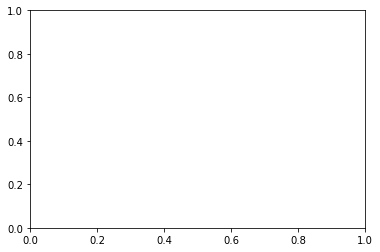

In [20]:
lr = ar.ctrl_data[ar.ctrl_mice[0]]['famnov'][0]
mu = np.nanmean(ar.ctrl_data[ar.ctrl_mice[0]]['mu'][0], axis=1)
fig, ax = plt.subplots()
ax.scatter(mu[lr==1,:].mean(axis=0), ar.ctrl_data[ar.ctrl_mice[0]]['place_cell_info'][0]['right']['SI'])

res = sp.stats.linregress(mu[lr==1,:].mean(axis=0), ar.ctrl_data[ar.ctrl_mice[0]]['place_cell_info'][0]['right']['SI'])

In [ ]:
mouse, day = ar.ko_mice[2], 3
lr = ar.ko_data[mouse]['famnov'][day]
mu = np.nanmean(ar.ko_data[mouse]['mu'][day], axis=1)
fig, ax = plt.subplots(2,2, figsize= [10,10], sharex = True)
ax[0, 0].scatter(mu[lr==1,:].mean(axis=0), ar.ko_data[mouse]['place_cell_info'][day]['right']['SI'])
ax[0, 0].vlines(1, 0, 1.2, color='red')
r,p = sp.stats.spearmanr(mu[lr==1,:].mean(axis=0), ar.ko_data[mouse]['place_cell_info'][day]['right']['SI'])
print('right', r, p)



ax[0,1].scatter(mu[lr==1,:].mean(axis=0), ar.ko_data[mouse]['place_cell_info'][day]['left']['SI'])
r,p = sp.stats.spearmanr(mu[lr==1,:].mean(axis=0), ar.ko_data[mouse]['place_cell_info'][day]['left']['SI'])
print('left', r, p)

In [ ]:
print(res)

In [ ]:


ctrl_mu, ctrl_bmu, speed, _, ctrl_lr = ar.make_plot_arr(ar.ctrl_data,0)
ko_mu, ko_bmu, speed, _, ko_lr = ar.make_plot_arr(ar.ko_data,0)

In [ ]:
print(ctrl_mu.shape, ko_mu.shape)
print(ctrl_bmu.shape, ko_bmu.shape)

In [ ]:
for i in range(5):
    fig,ax = plt.subplots(1,4, figsize= [20,5])
    fig.subplots_adjust(wspace=.5)
    combined_mu = np.log(np.concatenate((ctrl_bmu[i,:,:], ctrl_mu[i,:,:]), axis=0))
    mu = np.log(ctrl_mu[i,:,:])
    mask = ctrl_lr[i,:] ==1
    h = ax[0].imshow(combined_mu, vmin=-1, vmax=1, cmap='seismic')
    fig.colorbar(h,ax = ax[0])
    ax[0].set_yticks([0, 10, 20, 30, 40])
    ax[0].set_yticklabels([-10, 0, 10, 20, 30])
    ax[0].set_ylabel('Trials')
    ax[0].set_xlabel('Position')
    ax[0].set_title('All Trials')
    
    ax[1].imshow(mu[mask,:], vmin=-1, vmax=1, cmap='seismic')
    ax[1].set_ylabel('Trials')
    ax[1].set_xlabel('Position')
    ax[1].set_title('Familiar Trials')
    
    
    ax[2].imshow(mu[~mask,:], vmin=-1, vmax=1, cmap='seismic')
    ax[2].set_ylabel('Trials')
    ax[2].set_xlabel('Position')
    ax[2].set_title('Novel Trials')
    
    ax[3].plot(np.nanmean(mu[mask,:],axis=0))
    ax[3].plot(np.nanmean(mu[~mask,:], axis=0))
    
    fig.savefig(os.path.join(figdir,"%s_trial_heatmaps.pdf" % ctrl_mice[i]), format='pdf')

In [ ]:
for i in range(5):
    fig,ax = plt.subplots(1,4, figsize= [20,5])
    fig.subplots_adjust(wspace=.5)
    combined_mu = np.log(np.concatenate((ko_bmu[i,:,:], ko_mu[i,:,:]), axis=0))
    mu = np.log(ko_mu[i,:,:])
    mask = ctrl_lr[i,:] ==1
    h = ax[0].imshow(combined_mu, vmin=-1, vmax=1, cmap='seismic')
    fig.colorbar(h,ax = ax[0])
    ax[0].set_yticks([0, 10, 20, 30, 40])
    ax[0].set_yticklabels([-10, 0, 10, 20, 30])
    ax[0].set_ylabel('Trials')
    ax[0].set_xlabel('Position')
    ax[0].set_title('All Trials')
    
    ax[1].imshow(mu[mask,:], vmin=-1, vmax=1, cmap='seismic')
    ax[1].set_ylabel('Trials')
    ax[1].set_xlabel('Position')
    ax[1].set_title('Familiar Trials')
    
    
    ax[2].imshow(mu[~mask,:], vmin=-1, vmax=1, cmap='seismic')
    ax[2].set_ylabel('Trials')
    ax[2].set_xlabel('Position')
    ax[2].set_title('Novel Trials')
    
    ax[3].plot(np.nanmean(mu[mask,:],axis=0))
    ax[3].plot(np.nanmean(mu[~mask,:], axis=0))
    
    fig.savefig(os.path.join(figdir,"%s_trial_heatmaps.pdf" % ko_mice[i]), format='pdf')

<ipython-input-80-8efc1cee4cd0>:3: RuntimeWarning: Mean of empty slice
  ax[1].imshow(np.nanmean(ko_mu, axis=0), vmin = 1, vmax = 2, cmap='magma')
<ipython-input-80-8efc1cee4cd0>:4: RuntimeWarning: Mean of empty slice
  ax[2].imshow(np.nanmean(ctrl_mu, axis=0) - np.nanmean(ko_mu, axis=0), cmap='seismic', vmin=-1, vmax = 1)


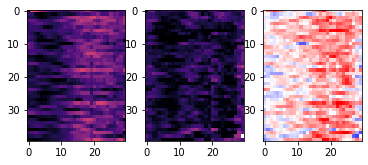

In [80]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(np.nanmean(ctrl_mu, axis=0), vmin = 1, vmax = 2, cmap='magma')
ax[1].imshow(np.nanmean(ko_mu, axis=0), vmin = 1, vmax = 2, cmap='magma')
ax[2].imshow(np.nanmean(ctrl_mu, axis=0) - np.nanmean(ko_mu, axis=0), cmap='seismic', vmin=-1, vmax = 1)

<ipython-input-81-336e5a105740>:6: RuntimeWarning: Mean of empty slice
  mu, sem = ar.mu_sem(np.nanmean(ko_mu, axis=0))


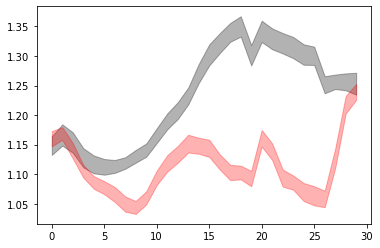

In [81]:
fig, ax = plt.subplots(sharey = True)
x = np.arange(30)
mu, sem = ar.mu_sem(np.nanmean(ctrl_mu, axis=0))
ax.fill_between(x, mu-sem, mu+sem, alpha = .3, color='black')

mu, sem = ar.mu_sem(np.nanmean(ko_mu, axis=0))
ax.fill_between(x, mu-sem, mu+sem, alpha = .3, color='red')

In [51]:
t,p = sp.stats.ranksums(np.nanmean(ko_mu[:,10:],axis=-1), np.nanmean(ctrl_mu[:,10:],axis=-1))
print(t,p)

-0.5222329678670935 0.6015081344405899


In [ ]:
# plot change in activity rate as a function of position

# correlate change in activity rate with spatial information or just whether or not its a place cell (both familiar and novel)

# check raw data to make sure there's no funny business